## Fall 2020 CS 4641\7641 A: Machine Learning Homework 3

## Instructor: Dr. Mahdi Roozbahani


In [2]:
# HELPER CELL, DO NOT MODIFY
# This is cell which sets up some of the modules you might need 
# Please do not change the cell or import any additional packages. 

import numpy as np
import json
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_extraction import text
from sklearn.datasets import load_boston, load_diabetes, load_digits, load_breast_cancer, load_iris, load_wine
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import floyd_warshall
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

## 1. Image compression with SVD [30 pts]  <span style="color:blue">**[P]**</span>  <span style="color:green">**[W]**</span>


### Load images data and plot


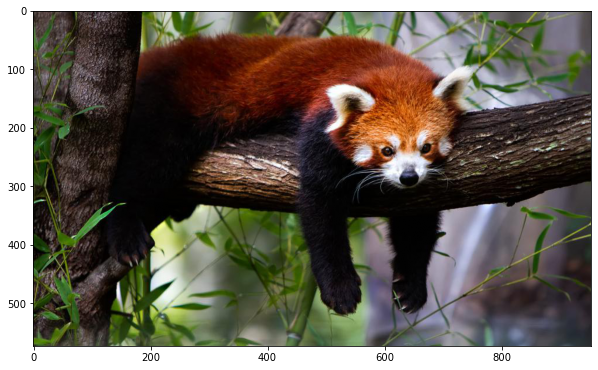

In [3]:
# load Image
image = plt.imread("hw3_image_2.jpg")/255.
#plot image
fig = plt.figure(figsize=(10,10))
plt.imshow(image)

3


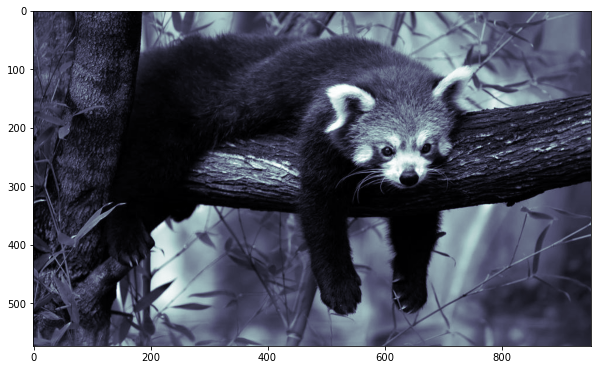

In [8]:
def rgb2gray(rgb):   
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

fig = plt.figure(figsize=(10, 10))
# plot several images
plt.imshow(rgb2gray(image), cmap=plt.cm.bone)

### 1.1 Image compression [20pts]  <span style="color:blue">**[P]**</span>

SVD is a dimensionality reduction technique that allows us to compress images by throwing away the least important information.  

Higher singular values capture greater variance and thus capture greater information from the corresponding singular vector. To perform image compression, apply SVD on each matrix and get rid of the small singular values to compress the image. The loss of information through this process is negligible and the difference between the images can hardly be spotted. For example, the variance captured by the first component $$\frac{\sigma_1}{\sum_{i=1}^n \sigma_i}$$ where $\sigma_i$ is the $i^{th}$ singular value. You need to finish the following functions to do SVD and then reconstruct the image by components. 

**Hint 1:** http://timbaumann.info/svd-image-compression-demo/ is an useful article on image compression.

In [9]:
class ImgCompression(object):
    def __init__(self):
        pass

    def svd(self, X): # [5pts]
        """
        Do SVD. You could use numpy SVD.
        Your function should be able to handle black and white
        images (N*D arrays) as well as color images (N*D*3 arrays)
        In the image compression, we assume that each colum of the image is a feature. Image is the matrix X.
        Args:
            X: N * D array corresponding to an image (N * D * 3 if color image)
        Return:
            U: N * N for black and white images / N * N * 3 for color images
            S: min(N, D) * 1 for black and white images / min(N, D) * 3 for color images
            V: D * D for black and white images / D * D * 3 for color images
        """
        N = X.shape[0]
        D = X.shape[1]
        Sdim  = D if D < N else N
        if len(X.shape) == 3:
            U = np.zeros((N, N, 3))
            S = np.zeros((Sdim, 3))
            V = np.zeros((D, D, 3))
            for i in range(3):
                Ui, Si, Vi = np.linalg.svd(X[...,i], full_matrices=True)
                U[...,i] = Ui
                S[...,i] = Si
                V[...,i] = Vi
        else:
            U, S, V = np.linalg.svd(X, full_matrices=True)
        return U, S, V

    def rebuild_svd(self, U, S, V, k): # [5pts]
        """
        Rebuild SVD by k componments.
        Args:
            U: N*N (*3 for color images)
            S: min(N, D)*1 (*3 for color images)
            V: D*D (*3 for color images)
            k: int corresponding to number of components
        Return:
            Xrebuild: N*D array of reconstructed image (N*D*3 if color image)

        Hint: numpy.matmul may be helpful for reconstructing color images
        """

        N = U.shape[0]
        D = V.shape[1]
        #print("D:",D)
        Sdim = D if D < N else N
        if len(U.shape) == 3: 
            image = np.zeros((N, D,  3))
            for i in range(3):
                Uk = np.zeros((N,N))
                #print(U[:,:k,i].shape)
                Uk[...,:k] = U[:,:k,i]
                Sk = np.zeros((N, D))
                Sk[:k,:k] = np.diag(S[:k, i])
                Vk = np.zeros((D,D))
                Vk[:k,...] = V[:k,:,i]
                #print("Uk.shape:", Uk.shape, " Sk.shape:", Sk.shape, " i", i)
                us = np.matmul(Uk, Sk)
                svdi = np.matmul(us, Vk)
                image[...,i] = svdi
        else:
            image = np.zeros((N,D))
            Uk = np.zeros(U.shape)
            Uk[...,:k] = U[:,:k]
            Sk = np.zeros((N, D))
            Sk[:k,:k] = np.diag(S[:k])
            Vk = np.zeros(V.shape)
            Vk[:k,...] = V[:k,:]
            us = np.matmul(Uk, Sk)
            svdi = np.matmul(us, Vk)
            image[...] = svdi
        return image

    def compression_ratio(self, X, k): # [5pts]
        """
        Compute compression of an image: (num stored values in compressed)/(num stored values in original)
        Args:
            X: N * D array corresponding to an image (N * D * 3 if color image)
            k: int corresponding to number of components
        Return:
            compression_ratio: float of proportion of storage used by compressed image
        """
        
        N = X.shape[0]
        D = X.shape[1]
        return (k * (1 + N + D))/(N*D)

    def recovered_variance_proportion(self, S, k): # [5pts]
        """
        Compute the proportion of the variance in the original matrix recovered by a rank-k approximation

        Args:
           S: min(N, D)*1 (*3 for color images) of singular values for the image
           k: int, rank of approximation
        Return:
           recovered_var: float (array of 3 floats for color image) corresponding to proportion of recovered variance
        """
        
        if len(S.shape) == 2:
            arr = []
            for i in range(3):
                # print(S[:k,i].shape)
                m = np.dot(S[:k,i].T, S[:k,i]) / np.dot(S[:,i].T, S[:,i])
                # print(m, "l")
                arr.append(m)
        else:
            # print('d')
            arr = (np.dot(S[:k].T, S[:k])) / (np.dot(S.T, S))
        return arr

### 1.2 Black and white [5 pts] <span style="color:green">**[W]**</span>
Use your implementation to generate a set of images compressed to different degrees. Include the images in your non-programming submission to the assignment.

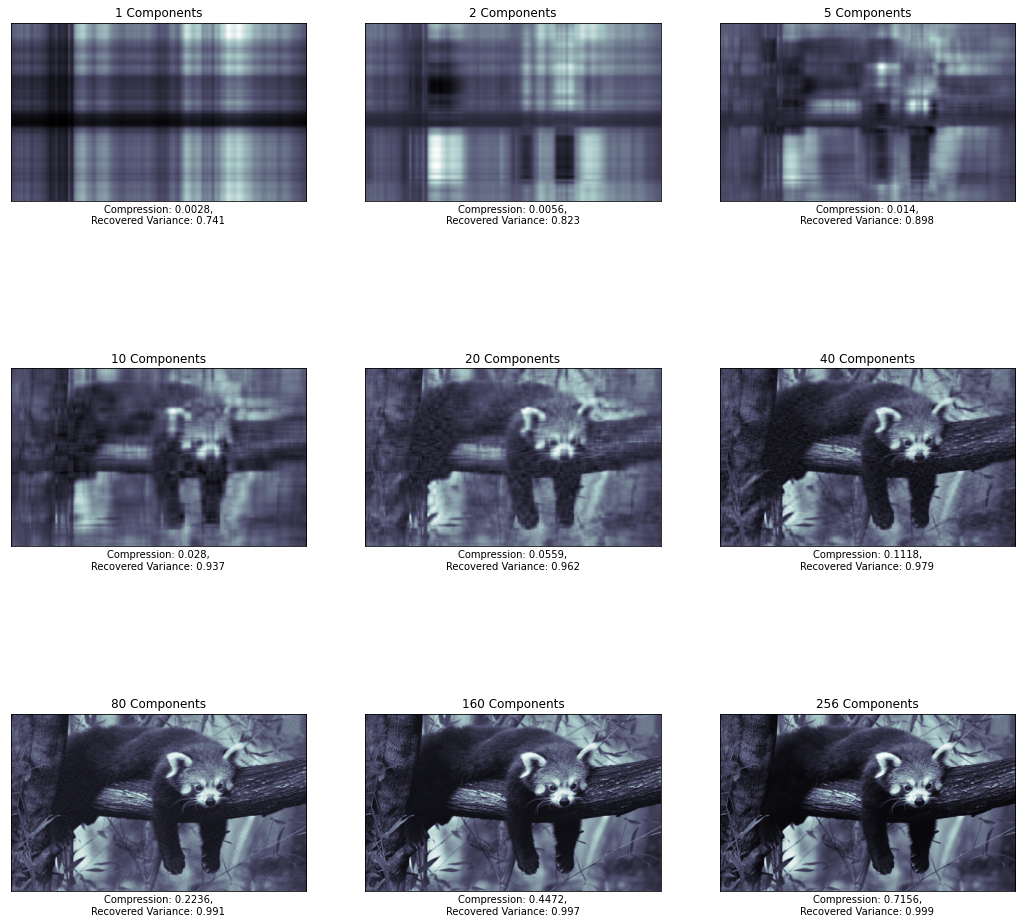

In [12]:
# HELPER CELL, DO NOT MODIFY
imcompression = ImgCompression()
bw_image = rgb2gray(image)
U, S, V = imcompression.svd(bw_image)
component_num = [1,2,5,10,20,40,80,160,256]

fig = plt.figure(figsize=(18, 18))

# plot several images
i=0
for k in component_num:
    img_rebuild = imcompression.rebuild_svd(U, S, V, k)
    c = np.around(imcompression.compression_ratio(bw_image, k), 4)
    r = np.around(imcompression.recovered_variance_proportion(S, k), 3)
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img_rebuild, cmap=plt.cm.bone)
    ax.set_title(f"{k} Components")
    ax.set_xlabel(f"Compression: {c},\nRecovered Variance: {r}")
    i = i+1

### 1.3 Color image [5 pts] <span style="color:green">**[W]**</span>
Use your implementation to generate a set of images compressed to different degrees. Include the images in your non-programming submission to the assignment.

<b>Note:</b> You might get warning "Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)." This warning is acceptable since while rebuilding some of the pixels may go above 1.0. You should see similar image to original even with such clipping.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


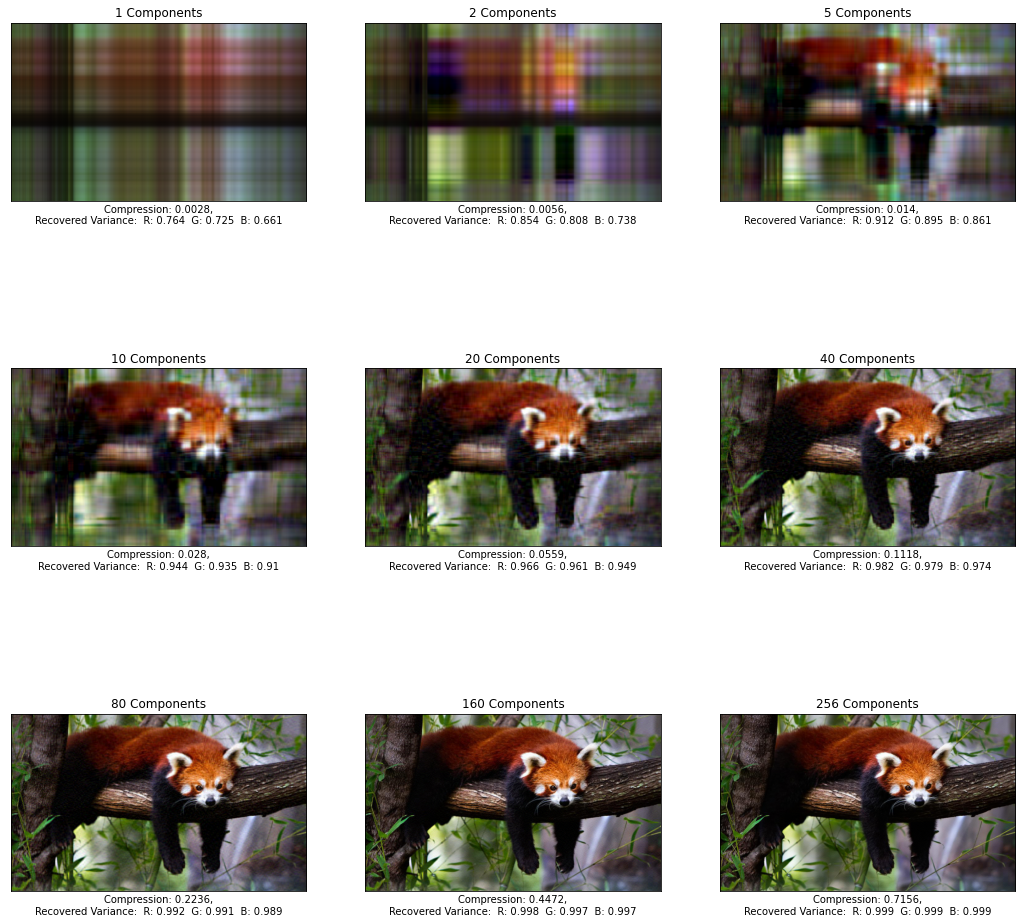

In [13]:
# HELPER CELL, DO NOT MODIFY
imcompression = ImgCompression()
U, S, V = imcompression.svd(image)

# component_num = [1,2,5,10,20,40,80,160,256]
component_num = [1,2,5,10,20,40,80,160,256]

fig = plt.figure(figsize=(18, 18))

# plot several images
i=0
for k in component_num:
    img_rebuild = imcompression.rebuild_svd(U, S, V, k)
    c = np.around(imcompression.compression_ratio(image, k), 4)
    r = np.around(imcompression.recovered_variance_proportion(S, k), 3)
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(img_rebuild)
    ax.set_title(f"{k} Components")
    ax.set_xlabel(f"Compression: {np.around(c,4)},\nRecovered Variance:  R: {r[0]}  G: {r[1]}  B: {r[2]}")
    i = i+1

## 2 Understanding PCA [15 pts] <span style="color:blue">**[P]**</span> | <span style="color:green">**[W]**</span>

### 2.1 Implementation [10 pts] <span style="color:blue">**[P]**</span>

[Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) is another dimensionality reduction technique that reduces dimensions by eliminating small variance eigenvalues and their vectors. With PCA, we center the data first by subtracting the mean. Each singular value tells us how much of the variance of a matrix (e.g. image) is captured in each component. In this problem, we will investigate how PCA can be used to improve features for regression and classification tasks and how the data itself affects the behavior of PCA.  

 

Implement PCA in the below cell. 

Assume a dataset is composed of N datapoints, each of which has D features with D < N. The dimension of our data would be D. It is possible, however, that many of these dimensions contain redundant information. Each feature explains part of the variance in our dataset. Some features may explain more variance than others. 

In the following cell complete the PCA class by completing functions fit, transform and transform_rv. 

In [7]:
class PCA(object):

    def __init__(self):
        self.U = None
        self.S = None
        self.V = None

    def fit(self, X): # 5 points
        """
        Decompose dataset into principal components.
        You may use your SVD function from the previous part in your implementation or numpy.linalg.svd function.

        Don't return anything. You can directly set self.U, self.S and self.V declared in __init__ with
        corresponding values from PCA.

        Args:
            X: N*D array corresponding to a dataset
        Return:
            None
        """
        
        X_hat = X - np.mean(X, axis=0).reshape(1, X.shape[1])
        self.U, self.S, self.V = np.linalg.svd(X_hat, full_matrices=False)


    def transform(self, data, K=2): # 2 pts
        """
        Transform data to reduce the number of features such that final data has given number of columns

        Utilize self.U, self.S and self.V that were set in fit() method.

        Args:
            data: N*D array corresponding to a dataset
            K: Int value for number of columns to be kept
        Return:
            X_new: N*K array corresponding to data obtained by applying PCA on data
        """
        
        n = data.shape[0]
        s = np.dot(self.S, self.S) / n
        v = np.matmul(data, self.V.T)[..., :K]
        return v

    def transform_rv(self, data, retained_variance=0.99): # 3 pts
        """
        Transform data to reduce the number of features such that a given variance is retained

        Utilize self.U, self.S and self.V that were set in fit() method.

        Args:
            data: N*D array corresponding to a dataset
            retained_variance: Float value for amount of variance to be retained
        Return:
            X_new: N*K array corresponding to data obtained by applying PCA on data
        """

        s_sqr = np.dot(self.S, self.S)
        s_i = self.S * self.S
        s_i_cum = np.cumsum(s_i)
        s_var = s_i_cum / s_sqr
        k = np.where(s_var==retained_variance)[0]
        if (len(k) == 0) :
            k = np.argmin(s_var - retained_variance * ((s_var - retained_variance) > 0))
        else:
            k = k[0]
        print(k)
        return self.transform(data, k)

    def get_V(self):
        """ Getter function for value of V """
        
        return self.V

### 2.2 Visualize [5 pts] <span style="color:green">**[W]**</span>

PCA is used to transform multivariate data tables into smaller sets so as to observe the hidden trends and variations in the data. Here you will visualize two datasets (iris and wine) using PCA. Use the above implementation of PCA and reduce the datasets such that they contain only two features. Make 2-D scatter plots of the data points using these features. Make sure to differentiate the data points according to their true labels. The datasets have already been loaded for you. In addition, return the retained variance obtained from the reduced features.

In [8]:
def visualize(X,y): # 5 pts
    """
    Args:
        xtrain: NxD numpy array, where N is number of instances and D is the dimensionality of each instance
        ytrain: numpy array (N,), the true labels
  
    Return:
        None
    """
    
    pca = PCA()
    pca.fit(X)
    new_data = pca.transform(X)
    print(new_data.shape)
    plt.scatter(x=new_data[:,0], y=new_data[:,1], c=y)
    plt.show

data shape with PCA  (150, 2)


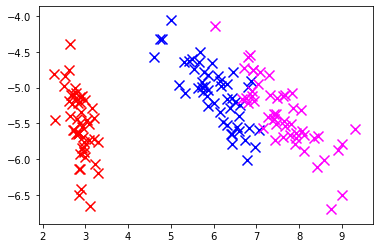

In [9]:
# HELPER CELL, DO NOT MODIFY
#Use PCA for visualization of iris and wine data
iris_data = load_iris(return_X_y=True)

X = iris_data[0]
y = iris_data[1]

visualize(X, y)

data shape with PCA  (178, 2)


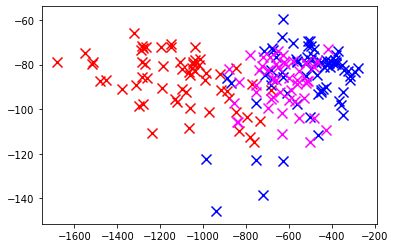

In [10]:
# HELPER CELL, DO NOT MODIFY
wine_data = load_wine(return_X_y=True)

X = wine_data[0]
y = wine_data[1]

visualize(X, y)

Now you will use PCA on an actual real-world dataset. We will use your implementation of PCA function to reduce the dataset with 99% retained variance and use it to obtain the reduced features. On the reduced dataset, we will use logistic or linear regression and compare results between PCA and non-PCA datasets. Run the following cells to see how PCA works on regression and classification tasks.

In [11]:
# HELPER CELL, DO NOT MODIFY
#load the dataset 
iris = load_iris()

X = iris.data
y = iris.target

print("data shape before PCA ",X.shape)

pca = PCA()
pca.fit(X)

X_pca = pca.transform_rv(X)

print("data shape with PCA ",X_pca.shape)

data shape before PCA  (150, 4)
data shape with PCA  (150, 3)


In [12]:
# HELPER CELL, DO NOT MODIFY
# Train, test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

# Use logistic regression to predict classes for test set
clf = LogisticRegression()
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.93333


In [13]:
# HELPER CELL, DO NOT MODIFY
# Train, test splits
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

# Use logistic regression to predict classes for test set
clf = LogisticRegression()
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.95556


In [14]:
# HELPER CELL, DO NOT MODIFY
def apply_regression(X_train, y_train, X_test):
    ridge = Ridge()
    weight = ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    
    return y_pred

In [15]:
# HELPER CELL, DO NOT MODIFY
#load the dataset 
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

print(X.shape, y.shape)

pca = PCA()
pca.fit(X)

X_pca = pca.transform_rv(X)
print("data shape with PCA ",X_pca.shape)

(442, 10) (442,)
data shape with PCA  (442, 8)


In [16]:
# HELPER CELL, DO NOT MODIFY
# Train, test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

#Ridge regression without PCA
y_pred = apply_regression(X_train, y_train, X_test)

# calculate RMSE 
rmse_score = np.sqrt(mean_squared_error(y_pred, y_test))
print("rmse score without PCA",rmse_score)

rmse score without PCA 55.79391924562032


In [17]:
# HELPER CELL, DO NOT MODIFY
#Ridge regression with PCA
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.3, random_state=42)

#use Ridge Regression for getting predicted labels
y_pred = apply_regression(X_train,y_train,X_test)

#calculate RMSE 
rmse_score = np.sqrt(mean_squared_error(y_pred, y_test))
print("rmse score with PCA",rmse_score)

rmse score with PCA 55.78489213087043


For both the tasks above we see an improvement in performance by reducing our dataset with PCA.


## 3 Polynomial regression and regularization [55 pts + 20 pts bonus for CS 4641] <span style="color:green">**[W]**</span> | <span style="color:blue">**[P]**</span>

### 3.1 Regression and regularization implementations [30 pts + 20 pts bonus for CS 4641] <span style="color:blue">**[P]**</span>
We have three methods to fit linear and ridge regression models: 1) close form; 2) gradient descent (GD); 3) Stochastic gradient descent (SGD). For undergraduate students, you are required to implement the closed form for linear regression and for ridge regression, the others 4 methods are bonus parts. For graduate students, you are required to implement all of them. We use the term weight in the following code. Weights and parameters ($\theta$) have the same meaning here. We used parameters ($\theta$) in the lecture slides.

In [19]:
class Regression(object):
    
    def __init__(self):
        pass
    
    def rmse(self, pred, label): # [5pts]
        '''
        This is the root mean square error.
        Args:
            pred: numpy array of length N * 1, the prediction of labels
            label: numpy array of length N * 1, the ground truth of labels
        Return:
            a float value
        '''
        
        y = label-pred
        return np.dot(y.T, y) / pred.size
    
    def construct_polynomial_feats(self, x, degree): # [5pts]
        """
        Args:
            x: numpy array of length N, the 1-D observations
            degree: the max polynomial degree
        Return:
            feat: numpy array of shape Nx(degree+1), remember to include 
            the bias term. feat is in the format of:
            [[1.0, x1, x1^2, x1^3, ....,],
             [1.0, x2, x2^2, x2^3, ....,],
             ......
            ]
        """
        
        n = x.size
        d = degree+1
        ds = np.arange(d)
        x_new = x.reshape(n, 1) * np.ones((n, d))
        return np.power(x_new, ds)


    def predict(self, xtest, weight): # [5pts]
        """
        Args:
            xtest: NxD numpy array, where N is number 
                   of instances and D is the dimensionality of each 
                   instance
            weight: Dx1 numpy array, the weights of linear regression model
        Return:
            prediction: Nx1 numpy array, the predicted labels
        """
        
        return np.matmul(xtest, weight)
        
    # =================
    # LINEAR REGRESSION
    # Hints: in the fit function, use close form solution of the linear regression to get weights. 
    # For inverse, you can use numpy linear algebra function  
    # For the predict, you need to use linear combination of data points and their weights (y = theta0*1+theta1*X1+...)

    def linear_fit_closed(self, xtrain, ytrain): # [5pts]
        """
        Args:
            xtrain: N x D numpy array, where N is number of instances and D is the dimensionality of each instance
            ytrain: N x 1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        
        xTx = np.matmul(xtrain.T, xtrain)
        xTxInv = np.linalg.inv(xTx)
        xTy = np.matmul(xtrain.T, ytrain)
        return np.matmul(xTxInv, xTy)

    def linear_fit_GD(self, xtrain, ytrain, epochs=5, learning_rate=0.001): # [5pts]
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        
        n = xtrain.shape[0]
        weights = np.zeros((xtrain.shape[1], 1))
        for i in range(epochs):
            pred = np.dot(xtrain, weights)
            a = ytrain - pred
            summy = np.dot(xtrain.T, a)
            summy = (learning_rate/n) * summy
            weights = weights + summy
        return weights

    def linear_fit_SGD(self, xtrain, ytrain, epochs=100, learning_rate=0.001): # [5pts]
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        
        n = xtrain.shape[0]
        d = xtrain.shape[1]
        weights = np.zeros((d, 1))
        rand = np.random.randint(n, size=epochs)
        for i in rand:
            pred = np.dot(xtrain[i,:], weights)
            a = ytrain[i] - pred
            summy = np.dot(xtrain[i,:].T.reshape((d,1)), a.reshape((1,1)))
            summy = (learning_rate) * summy
            weights = weights + summy
        return weights
        
    # =================
    # RIDGE REGRESSION
        
    def ridge_fit_closed(self, xtrain, ytrain, c_lambda): # [5pts]
        """
        Args:
            xtrain: N x D numpy array, where N is number of instances and D is the dimensionality of each instance
            ytrain: N x 1 numpy array, the true labels
            c_lambda: floating number
        Return:
            weight: Dx1 numpy array, the weights of ridge regression model
        """
        
        xTx = np.matmul(xtrain.T, xtrain)
        xTx = xTx + np.eye(xTx.shape[0], xTx.shape[1])*c_lambda
        xTxInv = np.linalg.inv(xTx)
        xTy = np.matmul(xtrain.T, ytrain)
        return np.matmul(xTxInv, xTy)

        
    def ridge_fit_GD(self, xtrain, ytrain, c_lambda, epochs=500, learning_rate=1e-7): # [5pts]
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
            c_lambda: floating number
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        
        n = xtrain.shape[0]
        weights = np.zeros((xtrain.shape[1], 1))
        for i in range(epochs):
            # print("weights pre: ", weights)
            pred = np.dot(xtrain, weights)
            a = ytrain - pred
            summy = np.dot(xtrain.T, a)
            # print("summy: ", summy, " regularlization factor: ", 2*c_lambda*weights)
            summy = (learning_rate / n) * (summy + 2*c_lambda*weights)
            weights = weights + summy
        return weights


    def ridge_fit_SGD(self, xtrain, ytrain, c_lambda, epochs=100, learning_rate=0.001): # [5pts]
        """
        Args:
            xtrain: NxD numpy array, where N is number 
                    of instances and D is the dimensionality of each 
                    instance
            ytrain: Nx1 numpy array, the true labels
        Return:
            weight: Dx1 numpy array, the weights of linear regression model
        """
        
        n = xtrain.shape[0]
        d = xtrain.shape[1]
        weights = np.zeros((d, 1))
        rand = np.random.randint(n, size=epochs)
        for i in rand:
            # print("\nweights pre: ", weights)
            pred = np.dot(xtrain[i, :], weights)
            a = ytrain[i] - pred
            summy = np.dot(xtrain[i, :].T.reshape((d, 1)), a.reshape((1, 1)))
            # print("\nsummy: ", summy, "\n\n regularlization factor: ", 2*c_lambda*weights)
            summy = (learning_rate) * (summy + 2*c_lambda*weights)
            weights = weights + summy
        return weights

    def ridge_cross_validation(self, X, y, kfold=10, c_lambda=100): # [5 pts]
        """
        Args: 
            X : NxD numpy array, where N is the number of instances and D is the dimensionality of each instance
            y : Nx1 numpy array, true labels
            kfold: Number of folds you should take while implementing cross validation.
            c_lambda: Value of regularization constant
        Returns:
            meanErrors: Float average rmse error
        Hint: np.concatenate might be helpful.
        Look at 3.5 to see how this function is being used.
        # For cross validation, use 10-fold method and only use it for your training data (you already have the train_indices to get training data).
        # For the training data, split them in 10 folds which means that use 10 percent of training data for test and 90 percent for training.
        """
        
        n = y.size
        x_split = np.split(X, kfold)
        y_split = np.split(y, kfold)
        print(y_split)
        rsmeTot = 0
        for i in range(kfold):
            x_test = x_split[i]
            y_test = y_split[i]
            if i+1 < len(x_split):
                #print("x_SPLIT :i", x_split[:i])
                #print("x_SPLIT i+1:", x_split[i+1:])
                x_train = np.concatenate(x_split[:i] + x_split[i+1:])
                #print("Y_SPLIT :i", y_split[:i])
                #print("Y_SPLIT i+1:", y_split[i+1:])
                y_train = np.concatenate(y_split[:i] + y_split[i+1:])
            else:
                x_train = np.concatenate(x_split[:i])
                y_train = np.concatenate(y_split[:i])
            w_i = ridge_fit_closed(x_train, y_train, c_lambda)
            predi = predict(x_test, w_i)
            rsmei = rmse(predi, y_test)
            rsmeTot += rsmei
        return rsmeTot / kfold

### 3.2 About RMSE [3 pts] <span style="color:green">**[W]**</span>
Do you know whether this RMSE is good or not? If you don't know, we could normalize our labels between 0 and 1. After normalization, what does it mean when RMSE = 1? 

**Hint**: think of the way that you can enforce your RMSE = 1. Note that you can not change the actual labels to make RMSE = 1.

### 3.3 Testing: general functions and linear regression [5 pts] <span style="color:green">**[W]**</span>

Let's first construct a dataset for polynomial regression.

In this case, we construct the polynomial features up to degree 5..
Each data sample consists of two features $[a,b]$. We compute the polynomial features of both a and b in order to yield the vectors $[1,a,a^2,a^3, ... a^{degree}]$ and $[1,b,b^2,b^3, ... , b^{degree}]$. We train our model with the cartesian product of these polynomial features. The cartesian product generates a new feature vector consisting of all polynomial combinations of the features with degree less than or equal to the specified degree.

For example, if degree = 2, we will have the polynomial features $[1,a,a^2]$ and $[1,b,b^2]$ for the datapoint $[a,b]$. The cartesian product of these two vectors will be $[1,a,b,ab,a^2,b^2]$. We do not generate $a^3$ and $b^3$ since their degree is greater than 2 (specified degree).

In [6]:
#helper, do not need to change
POLY_DEGREE = 5
NUM_OBS = 1000

rng = np.random.RandomState(seed=4)

true_weight = -rng.rand((POLY_DEGREE)**2+2, 1)
true_weight[2:, :] = 0
x_all1 = np.linspace(-5, 5, NUM_OBS)
x_all2 = np.linspace(-3, 3, NUM_OBS)
x_all = np.stack((x_all1,x_all2), axis=1)

reg = Regression()
x_all_feat1 = reg.construct_polynomial_feats(x_all[:,0], POLY_DEGREE)
x_all_feat2 = reg.construct_polynomial_feats(x_all[:,1], POLY_DEGREE)

x_cart_flat = []
for i in range(x_all_feat1.shape[0]):
    x1 = x_all_feat1[i]
    x2 = x_all_feat2[i]
    x1_end = x1[-1]
    x2_end = x2[-1]
    x1 = x1[:-1]
    x2 = x2[:-1]
    x3 = np.asarray([[m*n for m in x1] for n in x2])

    x3_flat = np.reshape(x3, (x3.shape[0]**2))
    x3_flat = list(x3_flat)
    x3_flat.append(x1_end)
    x3_flat.append(x2_end)
    x3_flat = np.asarray(x3_flat)
    x_cart_flat.append(x3_flat)
    
x_cart_flat = np.asarray(x_cart_flat)
x_all_feat = np.copy(x_cart_flat)

y_all = np.dot(x_cart_flat, true_weight) + rng.randn(x_all_feat.shape[0], 1) # in the second term, we add noise to data
print(x_all_feat.shape, y_all.shape)

# Note that here we try to produce y_all as our training data
#plot_curve(x_all, y_all) # Data with noise that we are going to predict
#plot_curve(x_all, np.dot(x_cart_flat, true_weight), curve_type='-', color='r', lw=4) # the groundtruth information

indices = rng.permutation(NUM_OBS)

(1000, 27) (1000, 1)


(1000,) (1000,) (1000,)


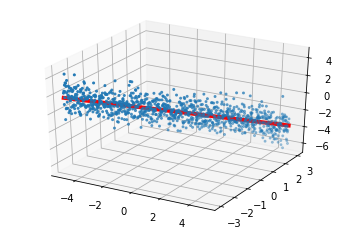

In [21]:
# HELPER CELL, DO NOT MODIFY
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

p = np.reshape(np.dot(x_cart_flat, true_weight), (1000,))
print(x_all[:,0].shape, x_all[:,1].shape,p.shape)
ax.plot(x_all[:,0], x_all[:,1], p, c="red",linewidth=4)
ax.scatter(x_all[:,0], x_all[:,1], y_all,s=4)

In the figure above, the red curve is the true fuction we want to learn, while the blue dots are the noisy observations. The observations are generated by  $Y=X\theta+σ$ , where  σ∼N(0,1)  are i.i.d. generated noise.

Now let's split the data into two parts, namely the training set and test set. The red dots are for training, while the blue dots are for testing.

(500, 2) (500, 2) (1000, 1)


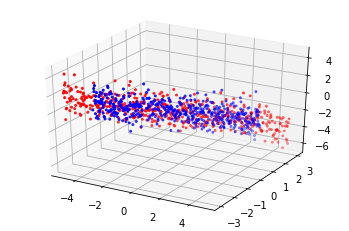

In [22]:
# HELPER CELL, DO NOT MODIFY
train_indices = indices[:NUM_OBS//2]
test_indices = indices[NUM_OBS//2:]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xtrain = x_all[train_indices]
ytrain = y_all[train_indices]
xtest = x_all[test_indices]
ytest = y_all[test_indices]

print(xtrain.shape, xtest.shape, y_all.shape)
ax.scatter(xtrain[:,0], xtrain[:,1], ytrain, c='r',s=4)
ax.scatter(xtest[:,1], xtest[:,1], ytest, c='b',s=4)

Now let's first train using the entire training set, and see how we performs on the test set and how the learned function look like.

In [23]:
# HELPER CELL, DO NOT MODIFY
weight = reg.linear_fit_closed(x_all_feat[train_indices], y_all[train_indices])
y_test_pred = reg.predict(x_all_feat[test_indices], weight)
test_rmse = reg.rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

test rmse: 0.9589


In [24]:
# HELPER CELL, DO NOT MODIFY
weight = reg.linear_fit_GD(x_all_feat[train_indices], y_all[train_indices], epochs=500000, learning_rate=1e-9)
y_test_pred = reg.predict(x_all_feat[test_indices], weight)
test_rmse = reg.rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

test rmse: 1.2971


And what if we just use the first 10 observations to train? 

In [25]:
# HELPER CELL, DO NOT MODIFY
sub_train = train_indices[:10]
weight = reg.linear_fit_closed(x_all_feat[sub_train], y_all[sub_train])
y_test_pred = reg.predict(x_all_feat[test_indices], weight)
test_rmse = reg.rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

test rmse: 5.2039


Did you see a worse performance? Let's take a closer look at what we have learned.

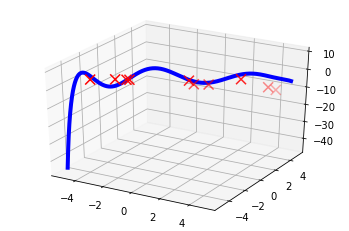

In [26]:
# HELPER CELL, DO NOT MODIFY
y_pred = reg.predict(x_all_feat, weight)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x1 = x_all[:,0]
x2 = x_all[:,0]
y_pred = np.reshape(y_pred, (1000,))
ax.plot(x1, x2, y_pred, color='b', lw=4)

x3 = x_all[sub_train,0]
x4 = x_all[sub_train,1]
ax.scatter(x3, x4, y_all[sub_train], s=100, c='r', marker='x')

y_test_pred = reg.predict(x_all_feat[test_indices], weight)

### 3.4.1 Testing: ridge regression [5 pts] <span style="color:green">**[W]**</span>

Now let's try ridge regression. Similarly, undergraduate students need to implement the closed form, and graduate students need to implement all the three methods. We will call the prediction function from linear regression part.

Again, let's see what we have learned. You only need to run the cell corresponding to your specific implementation.

(10, 27)
(10, 1)
test rmse: 1.4805


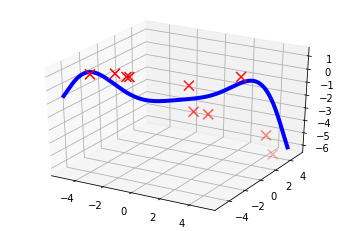

In [27]:
# HELPER CELL, DO NOT MODIFY
sub_train = train_indices[:10]
print(x_all_feat[sub_train].shape)
print(y_all[sub_train].shape)
weight = reg.ridge_fit_closed(x_all_feat[sub_train], y_all[sub_train], c_lambda=1000)

y_pred = reg.predict(x_all_feat, weight)

y_test_pred = reg.predict(x_all_feat[test_indices], weight)
test_rmse = reg.rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x1 = x_all[:,0]
x2 = x_all[:,0]
y_pred = np.reshape(y_pred, (1000,))
ax.plot(x1, x2, y_pred, color='b', lw=4)

x3 = x_all[sub_train,0]
x4 = x_all[sub_train,1]
ax.scatter(x3, x4, y_all[sub_train], s=100, c='r', marker='x')

y_test_pred = reg.predict(x_all_feat[test_indices], weight)

test rmse: 1.6795


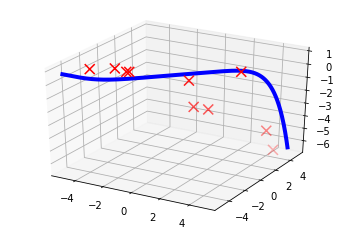

In [28]:
# HELPER CELL, DO NOT MODIFY
sub_train = train_indices[:10]
weight = reg.ridge_fit_GD(x_all_feat[sub_train], y_all[sub_train], c_lambda=1000, learning_rate=1e-9)

y_pred = reg.predict(x_all_feat, weight)

y_test_pred = reg.predict(x_all_feat[test_indices], weight)
test_rmse = reg.rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x1 = x_all[:,0]
x2 = x_all[:,0]
y_pred = np.reshape(y_pred, (1000,))
ax.plot(x1, x2, y_pred, color='b', lw=4)

x3 = x_all[sub_train,0]
x4 = x_all[sub_train,1]
ax.scatter(x3, x4, y_all[sub_train], s=100, c='r', marker='x')

y_test_pred = reg.predict(x_all_feat[test_indices], weight)

test rmse: 1.6719


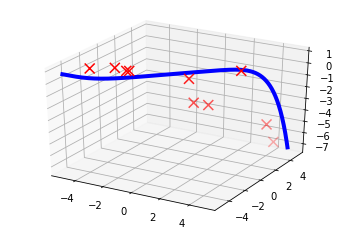

In [29]:
# HELPER CELL, DO NOT MODIFY
sub_train = train_indices[:10]
weight = reg.ridge_fit_SGD(x_all_feat[sub_train], y_all[sub_train], c_lambda=1000, learning_rate=1e-9)

y_pred = reg.predict(x_all_feat, weight)

y_test_pred = reg.predict(x_all_feat[test_indices], weight)
test_rmse = reg.rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x1 = x_all[:,0]
x2 = x_all[:,0]
y_pred = np.reshape(y_pred, (1000,))
ax.plot(x1, x2, y_pred, color='b', lw=4)

x3 = x_all[sub_train,0]
x4 = x_all[sub_train,1]
ax.scatter(x3, x4, y_all[sub_train], s=100, c='r', marker='x')

y_test_pred = reg.predict(x_all_feat[test_indices], weight)

### 3.4.2 Lasso and Ridge Regression [5 pts] <span style="color:green">**[W]**</span>
We train two linear regression models with different regularizations- one with lasso regularization and the other with ridge regularization. Let $w_1$ be the final weight vector for the model with lasso regularization and let $w_2$ be the final weight vector for the model with ridge regularization. How do $w_1$ and $w_2$ differ in terms of sparsity? For ridge regression, how do the weights change with change in lambda?

### 3.5 Cross validation [7 pts] <span style="color:green">**[W]**</span>
Let's use Cross Validation to find the best value for c_lambda in ridge regression.

In [30]:
# We provided 6 possible values for lambda, and you will use them in cross validation.
# For cross validation, use 10-fold method and only use it for your training data (you already have the train_indices to get training data).
# For the training data, split them in 10 folds which means that use 10 percent of training data for test and 90 percent for training.
# At the end for each lambda, you have caluclated 10 rmse and get the mean value of that.
# That's it. Pick up the lambda with the lowest mean value of rmse. 
# Hint: np.concatenate is your friend.
best_lambda = None
best_error = None
kfold = 10
lambda_list = [0.1, 1, 5, 10, 100, 1000]

for lm in lambda_list:
    err = reg.ridge_cross_validation(x_all_feat[train_indices], y_all[train_indices], kfold, lm)
    print('lambda: %.2f' % lm, 'error: %.6f'% err)
    if best_error is None or err < best_error:
        best_error = err
        best_lambda = lm

print('best_lambda: %.2f' % best_lambda)
weight = reg.ridge_fit_closed(x_all_feat[train_indices], y_all[train_indices], c_lambda=10)
y_test_pred = reg.predict(x_all_feat[test_indices], weight)
test_rmse = reg.rmse(y_test_pred, y_all[test_indices])
print('test rmse: %.4f' % test_rmse)  

lambda: 0.10 error: 1.015281
lambda: 1.00 error: 1.015235
lambda: 5.00 error: 1.015084
lambda: 10.00 error: 1.014995
lambda: 100.00 error: 1.019286
lambda: 1000.00 error: 1.035747
best_lambda: 10.00
test rmse: 0.9593


## 4. Naive Bayes Classification [20pts]

In Bayesian classification, we're interested in finding the probability of a label given some observed feature vector $x = [x_{1},.., x_{d}]$, which we can write as $P(y~|~{ x_{1},.., x_{d}})$.
Bayes's theorem tells us how to express this in terms of quantities we can compute more directly:

\begin{eqnarray} 
P(y~|~{ x_{1},.., x_{d}}) = \frac{P({ x_{1},.., x_{d}}~|~y)P(y)}{P({ x_{1},.., x_{d}})} 
\end{eqnarray}


The main assumption in Naive Bayes is that, given the label, the observed features are conditionally independent i.e. 

$$
P({ x_{1},.., x_{d}}~|~y) = P({x_{1}}~|~y) \times .. \times P({x_{d}}~|~y)    
$$

Therefore, we can rewrite Bayes rule as

\begin{eqnarray}
P(y~|~{ x_{1},.., x_{d}}) = \frac{P({x_{1}}~|~y) \times .. \times P({x_{d}}~|~y)P(y)}{P({ x_{1},.., x_{d}})}
\end{eqnarray}

### Training Naive Bayes
One way to train a Naive Bayes classifier is done using frequentist approach to calculate probability, which is simply going over the training data and calculating the frequency of different observations in the training set given different labels. For example,  
\begin{eqnarray}
P({x_{1}=i}~|~y=j) &=& \frac{P({x_{1}=i}, y=j)}{P(y=j)} =  \frac{\text{Number of times in training data } x_{1}=i \text{ and } y=j }{\text{Total number of times in training data } y=j}
\end{eqnarray}

### Testing Naive Bayes

During the testing phase, we try to estimate the probability of a label given an observed feature vector. We combine the probabilities computed from training data to estimate the probability of a given label. For example, if we are trying to decide between two labels $y_{1}$ and $y_{2}$, then we compute the ratio of the posterior probabilities for each label:

\begin{eqnarray}
\frac{P(y_{1}~|~ x_{1},.., x_{d})}{P(y_2~|~x_{1},.., x_{d})} = \frac{P(x_{1},.., x_{d}~|~y_{1})}{P(x_{1},.., x_{d}~|~y_{2})}\frac{P(y_1)}{P(y_2)}= \frac{P({x_{1}}~|~y_{1}) \times .. \times P({x_{d}}~|~y_{1})P(y_{1})}{P({x_{1}}~|~y_{2}) \times .. \times P({x_{d}}~|~y_{2})P(y_{2})}
\end{eqnarray}

All we need now is to compute $P(x_{1}|y_{i}),.., P(x_{d}~|~y_i)$ and $P(y_{i})$ for each label by pluging in the numbers we got during training. The label with the higher posterior probabilities is the one that is selected.

### 4.1 Bayes in Advertisements [5pts] <span style="color:green">**[W]**</span>


An advertising agency want to analyze the advertisements for a product. They want to target people from all age groups. They show 5 advertisement videos to 200 people. The following is the data on how many people from each group liked which videos. 

| Age Group    | Total | Video 1 | Video 2 | Video 3 | Video 4 | Video 5 |
|--------------|-------|---------|---------|---------|---------|---------|
| 16 - 35      | 100   | 20      | 30      | 60      | 15      | 90      |
| 36 - 55      | 60    | 15      | 50      | 30      | 20      | 40      |
| Above 55     | 40    | 35      | 30      | 10      | 10      | 5       |
| Total        | 200   | 70      | 110     | 100     | 45      | 135     |

A new consumer is shown the videos and he likes videos 2, 3 and 5. Which age group is he most likely to belong to?

Note: You can assume that each person provides opinion about each video independently i.e. Person 1 liking Video 1 has no effect on their assesment of Video 2.

### 4.2 The Federalist Papers [15pts] <span style="color:blue">**[P]**</span>

 [The Federalist Papers](https://en.wikipedia.org/wiki/The_Federalist_Papers) were a series of essays written in 1787–1788 meant to persuade the citizens of the State of New York to ratify the Constitution and which were published anonymously under the pseudonym “Publius”. In later years the authors were revealed as Alexander Hamilton, John Jay, and James Madison. However, there is some disagreement as to who wrote which essays. Hamilton wrote a list of which essays he had authored only days before being killed in a duel with then Vice President Aaron Burr. Madison wrote his own list many years later, which is in conflict with Hamilton’s list on 12 of the essays. Since by this point the two (who were once close friends) had become bitter rivals, historians have long been unsure as to the reliability of both lists. We will try to settle this dispute using a simple Naive Bayes classifier. 

The code which is provided loads the documents and builds a [“bag of words” representation](https://en.wikipedia.org/wiki/Bag-of-words_model)  of each document. Your task is to complete the missing portions of the code and to determine your best guess as to who wrote each of the 12 disputed essays. 
(Hint: H and M are the labels that stand for Hamilton and Madison, while the label D stands for disputed for the papers we are trying to label in our data. Our job here is to define whether D essays belong to H or M using Naive Bayes. Note that the label D for disputed, is completely unrelated to the feature dimension D which is an integer).

\_priors_ratio function calculates the ratio of class probabilities of document belonging to Hamilton as compared to Madison. We do this based on word counts rather than document counts.

\_likelihood_ratio function calculates the ratio of word probablities given the author it belonged to. 

**Note 1:** In \_likelihood_ratio() add one to each word count so as to avoid issues with zero word count. This is known as Add-1 smoothing. It is a type of additive smoothing. 

In [31]:
class NaiveBayes(object):

    def __init__(self):
        # load Documents
        x = open('fedpapers_split.txt').read()
        papers = json.loads(x)

        # split Documents
        papersH = papers[0] # papers by Hamilton 
        papersM = papers[1] # papers by Madison
        papersD = papers[2] # disputed papers

        # Number of Documents for H, M and D
        nH = len(papersH)
        nM = len(papersM)
        nD = len(papersD)
        
        '''To ignore certain common words in English that might skew your model, we add them to the stop words 
        list below. You may want to experiment by choosing your own list of stop words, but be sure to keep 
        'HAMILTON' and 'MADISON' in this list at a minimum, as their names appear in the text of the papers 
        and leaving them in could lead to unpredictable results '''

        stop_words = text.ENGLISH_STOP_WORDS.union({'HAMILTON','MADISON'})
        #stop_words = {'HAMILTON','MADISON'}
        # Form bag of words model using words used at least 10 times
        vectorizer = text.CountVectorizer(stop_words=stop_words,min_df=10)
        X = vectorizer.fit_transform(papersH+papersM+papersD).toarray()

        '''To visualize the full list of words remaining after filtering out stop words and words used less 
        than min_df times uncomment the following line'''
        #print(vectorizer.vocabulary_)

        # split word counts into separate matrices
        self.XH, self.XM, self.XD = X[:nH,:], X[nH:nH+nM,:], X[nH+nM:,:]
        

    def _likelihood_ratio(self, XH, XM): # [5pts]
        '''
        Args:
            XH: nH x D where nH is the number of documents that we have for Hamilton,
                while D is the number of features (we use the word count as the feature)
            XM: nM x D where nM is the number of documents that we have for Madison,
                while D is the number of features (we use the word count as the feature)
        Return:
            fratio: 1 x D vector of the likelihood ratio of different words (Hamilton/Madison)
        '''
        # Estimate probability of each word in vocabulary being used by Hamilton 
        
        # Estimate probability of each word in vocabulary being used by Madison 
        
        # Compute ratio of these probabilities
        
        XH[:, :] += 1
        total = np.sum(XH, axis=1).reshape(XH.shape[0], 1)
        summy = XH / total
        LH = np.mean(summy, axis=0)
        # print(LH)
        # print(LH.shape)
        XM[:, :] += 1
        total = np.sum(XM, axis=1).reshape(XM.shape[0], 1)
        summy = XM / total
        LP = np.mean(summy, axis=0)
        fratio = LH / LP
        # print(fratio)
        return fratio
    
    def _priors_ratio(self, XH, XM): # [5pts]
        '''
        Args:
            XH: nH x D where nH is the number of documents that we have for Hamilton,
                while D is the number of features (we use the word count as the feature)
            XM: nM x D where nM is the number of documents that we have for Madison,
                while D is the number of features (we use the word count as the feature)
        Return:
            pr: prior ratio of (Hamilton/Madison)
        '''
        # Compute prior probabilities 
        
        nH = np.sum(XH)
        nM = np.sum(XM)
        n = nH + nM
        return (nH / n) / (nM / n)

    def classify_disputed(self, fratio, pratio, XD): # [5pts]
        '''
        Args:
            fratio: 1 x D vector of ratio of likelihoods of different words
            pratio: 1 x 1 number
            XD: 12 x D bag of words representation of the 12 disputed documents (D = 1307 which are the number of features for each document)
        Return:
             1 x 12 list, each entry is H to indicate Hamilton or M to indicate Madison for the corrsponding document
        '''        
        
        a = []
        XD += 1
        for i in range(12):
            a.append("H" if np.prod(XD[i] * fratio) * pratio > 1 else "M")
        return a

In [32]:
# HELPER CELL, DO NOT MODIFY
NB = NaiveBayes()
fratio = NB._likelihood_ratio(NB.XH, NB.XM)
pratio = NB._priors_ratio(NB.XH, NB.XM)
resolved = NB.classify_disputed(fratio, pratio, NB.XD)
    
print(resolved)

['M', 'M', 'M', 'M', 'H', 'H', 'M', 'H', 'H', 'M', 'M', 'M']


## 5 Noise in PCA and Linear Regression (15 Pts) <span style="color:green">**[W]**</span>

Both PCA and least squares regression can be viewed as algorithms for inferring (linear) relationships
among data variables. In this part of the assignment, you will develop some intuition for the differences
between these two approaches, and an understanding of the settings that are better suited to using PCA or
better suited to using the least squares fit.

The high level bit is that PCA is useful when there is a set of latent (hidden/underlying)
variables, and all the coordinates of your data are linear combinations (plus noise) of those variables. The
least squares fit is useful when you have direct access to the independent variables, so any noisy coordinates
are linear combinations (plus noise) of known variables.

### 5.1 Slope Functions (5 Pts) <span style="color:green">**[W]**</span>

In the following cell:
1. For this function assume that X is the first feature and Y is the second feature for the data. Write a function pca_slope that takes a vector X of xi’s and a vector Y of yi’s and returns the slope of the first component of the PCA. 
2. Write a function linear_regression_slope that takes X and y and returns the slope of the least squares fit. (Hint: since X is one dimensional, this takes a particularly simple form1 $ ((X−\overline{X}) \cdot (Y − \overline{Y}))/\lVert X − \overline{X} \rVert_2^2$, where X is the mean value of X.)

In later subparts, we consider the case where our data consists of noisy measurements of x and y. For each
part, we will evaluate the quality of the relationship recovered by PCA, and that recovered by standard least
squares regression.

As a reminder, least squares regression minimizes the squared error of the dependent variable from its
prediction. Namely, given $(x_i, y_i)$ pairs, least squares returns the line $l(x)$ that minimizes $\sum_i (y_i − l(x_i))^2$.

**Note 1:** You should use the PCA and Linear Regression implementations from Q2 and Q3 in this question. Do not use any kind of regularization for Linear Regression.

In [33]:
def pca_slope(x, y):
    """
    Calculates the slope of the first principal component given by PCA

    Args: 
        x: (N,) vector of feature x
        y: (N,) vector of feature y
    Return:
        slope: slope of the first principal component
    """
    n = x.shape[0]
    xhat = x.reshape((n,1))-np.mean(x)
    yhat = y.reshape((n,1))-np.mean(y)
    xy = np.concatenate((xhat, yhat), axis=1)
    u, s, v = np.linalg.svd(xy, full_matrices=False)
    pc1 = v[0]
    slope = pc1[1] / pc1[0]
    """"fig = plt.figure()
    ax = plt.axes()
    a = np.linspace(0, 5, 500)
    ax.plot(a, slope*a)
    ax.plot(plt.scatter(x,y, c=np.random.rand(4)))
    plt.show() """
    #print(pc1, slope)
    return slope
    

def lr_slope(X, y):
    """
    Calculates the slope of the best fit as given by Linear Regression
    
    For this function don't use any regularization

    Args: 
        X: N*1 array corresponding to a dataset
        y: N*1 array of labels y
    Return:
        slope: slope of the best fit
    """
    
    lr = Regression()
    weight = lr.linear_fit_closed(X,y)
    return weight[0]

We will consider a simple example with two variables, x and y, where the true relationship between the
variables is y = 2x. Our goal is to recover this relationship—namely, recover the coefficient “2”. We set X = [0, .01, .02, .03, . . . , 1] and y = 2x. Make sure both functions return 2.

Slope of first principal component 2.0
Slope of best linear fit 2.0


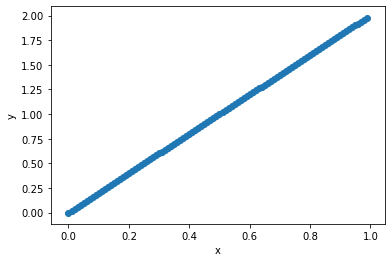

In [34]:
# HELPER CELL, DO NOT MODIFY
x = np.arange(0, 1, 0.01)
y = 2 * np.arange(0, 1, 0.01)

print("Slope of first principal component", pca_slope(x, y))

print("Slope of best linear fit", lr_slope(x[:, None], y))

plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### 5.2 Analysis Setup (5 Pts) <span style="color:green">**[W]**</span>

### Error in y

In this subpart, we consider the setting where our data consists of the actual values of $x$, and noisy estimates of $y$. Run the following cell to see how the data looks when there is error in $y$.

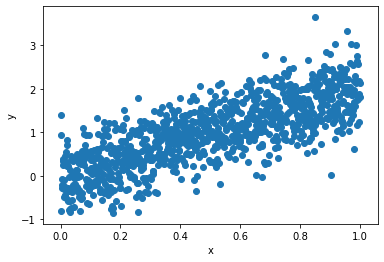

In [35]:
# HELPER CELL, DO NOT MODIFY
base = np.arange(0.001, 1, 0.001)
c = 0.5
X = base
y = 2 * base + np.random.normal(loc=[0], scale=c, size=base.shape)

plt.scatter(X, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In the subsequent cell implement the following:
1. Fix $X = [x_1, x_2, . . . , x_{1000}] = [.001, .002, .003, . . . , 1]$.
2. For a given noise level $c$, set $ \hat{y}_i ∼ 2x_i + \mathcal{N}(0, c) = 2i/1000 + \mathcal{N}(0, c)$, and $\hat{Y} = [\hat{y}_1, \hat{y}_2, . . . , \hat{y}_{1000}]$
3. Make a scatter plot with c on the horizontal axis, and the output of pca-slope and ls-slope on the vertical axis.
4. For each $c$ in $[0, 0.05, 0.1, . . . , .95, 1.0]$, take a sample $\hat{Y}$, plot the output of pca-recover as a red dot, and the output of ls-recover as a blue dot. Repeat 30 times. You should end up with a plot of 1260 dots, in 21 columns of 60, half red and half blue.

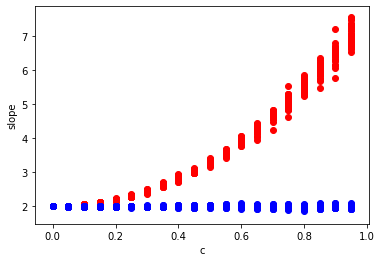

In [36]:
pca_slope_values = []
linreg_slope_values = []
c_values = []

for i in range(30):
    for c in np.arange(0, 1, 0.05):
        ####### YOUR CODE BELOW #######
        
        ###############################

        c_values.append(c)

plt.scatter(c_values, pca_slope_values, c='r')
plt.scatter(c_values, linreg_slope_values, c='b')
plt.xlabel("c")
plt.ylabel("slope")
plt.show()

### Error in x and y

We now examine the case where our data consists of noisy estimates of both $x$ and $y$. Run the following cell to see how the data looks when there is error in both.

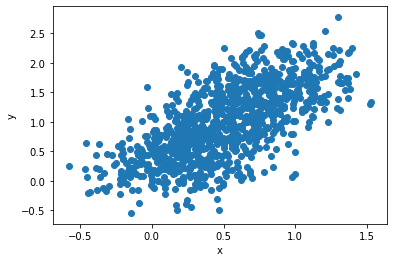

In [37]:
# HELPER CELL, DO NOT MODIFY
base = np.arange(0.001, 1, 0.001)
c = 0.5
X = base + np.random.normal(loc=[0], scale=c, size=base.shape) * 0.5
y = 2 * base + np.random.normal(loc=[0], scale=c, size=base.shape) * 0.5

plt.scatter(X, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In the subsequent cell implement the following:
1. For a given noise level c, let $\hat{x}_i ∼ x_i + \mathcal{N}(0, c) = i/1000 + \mathcal{N}(0, c)$, and $\hat{X} = [\hat{x}_1, \hat{x}_2, . . . . \hat{x}_{1000}]$
2. For the same noise level c, set $ \hat{y}_i ∼ 2x_i + \mathcal{N}(0, c) = 2i/1000 + \mathcal{N}(0, c)$, and $\hat{Y} = [\hat{y}_1, \hat{y}_2, . . . , \hat{y}_1000]$
3. Make a scatter plot with c on the horizontal axis, and the output of pca-slope and ls-slope on the vertical axis. For each $c$ in $[0, 0.05, 0.1, . . . , .95, 1.0]$, take a sample of both $\hat{X}$ and $\hat{Y}$, plot the output of pca-recover as a red dot, and the output of ls-recover as a blue dot. Repeat 30 times. You should end up with a plot of 1260 dots, in 21 columns of 60, half red and half blue.

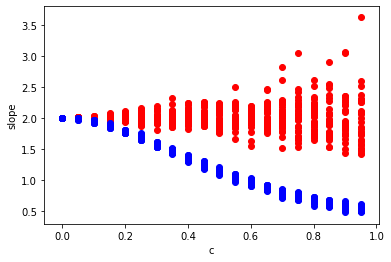

In [38]:
pca_slope_values = []
linreg_slope_values = []
c_values = []

for i in range(30):
    for c in np.arange(0, 1, 0.05):
        ####### YOUR CODE BELOW #######
        
        ###############################

        c_values.append(c)

plt.scatter(c_values, pca_slope_values, c='r')
plt.scatter(c_values, linreg_slope_values, c='b')
plt.xlabel("c")
plt.ylabel("slope")
plt.show()

### 5.3. Analysis (5 Pts) <span style="color:green">**[W]**</span>
Based on your observations from previous subsections answer the following questions about the two cases (error in $X$ and error in both $X$ and $Y$) in 2-3 lines. 

Note: 
1. The closer the value of slope to actual slope ("2" here) the better the algorithm is performing.
2. You don't need to provide a proof for this question.

Questions:
1. Which case does PCA perform worse in? Why does PCA perform worse in this case? <br>
- PCA performed worse in the case of Error in Y. This is becasue the PCA algorithim strives to maximize
the variance of a dataset projected on the component. In this example it seeks to the the slope that
when the data is projected onto that line, the variance of the projections is maximixed. As we increase
the noise (specifically the c value that corresponds to the variance of the noise) in the solely the y axis
the ratio of the var(y) to var(x) grows larger and larger so the slope that maximizes variance becomes
more vertically aligned and further from the expected outcome. This is opposed to noise in X&Y where
the ratio of variance in each direction remains largely unchanged as c scales and as a result the slope
of the first component is more centered around the expected slope.
2. Why does PCA perform better in the other case? <br>
- Extending on explanation from question 1, the case where there is noise in both X & Y, the variance of
the data is not skewed to one dimension as in the case where there is noise in soley Y. As a result the
slope of the PCA that maximizes the variance of porjected data is remains centered around theexpected outcome and is not skewed towards one axis.
3. Which case does Linear Regression perform well? Why does Linear Regression perform well in this case? <br>
- Linear regression performs well in the case where there is noise in Y and X is fixed. This is because X is
fixed and the noise is only applied to the Y axis. Linear regression finds the line that minimizes the
distance from each y point in training data so if the noise is spread with a gaussian dist about a line
with slope 2, then the mean of these distances will even out to the gaussian mean (0) and center on the
line with slope 2; therefore the predicted slope should not vary much from the expected.